[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/colab-github-demo.ipynb)

# <center> Homework </center>
---

The goal of this homework is to train a simple model for predicting the duration of a ride - similar to what we did in this module.

In [1]:
import os
import shutil
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.rc('figure', dpi=100)

---
---

## Q1. Downloading the data

We'll use [the same NYC taxi dataset](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page), but instead of "__Green__ Taxi Trip Records", we'll use "__Yellow__ Taxi Trip Records".

Download the data for January and February 2022.

Read the data for January. How many columns are there?
- 16
- 17
- 18
- 19 - _correct_

In [3]:
jan_url = 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-01.parquet'
feb_url = 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-02.parquet'

In [4]:
def download_data(url: str):
    print("Downloading data from ", url)
    filename = os.path.basename(url)
    filepath = os.path.join('data', filename)
    if not os.path.isfile(filepath):
        os.system(f'wget {url} -nv')
        shutil.move(filename, filepath)
    print('Done!')
    return filepath

In [5]:
jan_file = download_data(jan_url)
feb_file = download_data(feb_url)

Done!
Done!


In [6]:
df = pd.read_parquet(jan_file)

df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.0,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.0,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.5,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0


In [7]:
print('There are', len(df.columns), 'columns.')

There are 19 columns.


---
---

## Q2. Computing duration

Now let's compute the duration variable. It should contain the duration of a ride in minutes.

What's the standard deviation of the trips duration in January?
- 46.45 - _correct_
- 41.45
- 56.45
- 51.45

In [8]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df['duration'] = df.duration.dt.total_seconds() / 60

In [9]:
print(f'Mean: {df.duration.mean():.2f}')
print(f'Standard Dev.: {df.duration.std():.2f}')

Mean: 14.21
Standard Dev.: 46.45


## Q3. Dropping outliers

Next, we need to check the distribution of the duration variable. There are some outliers. Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

What fraction of the records left after you dropped the outliers?
- 90%
- 92%
- 95%
- 98% - _correct_

In [10]:
mask = (df.duration >= 1) & (df.duration <= 60)
pct = len(df[mask]) / len(df) * 100
df = df[mask].copy()

print(f'Fraction of records left after dropping the outliers: {pct:.0f}%')

Fraction of records left after dropping the outliers: 98%


## Q4. One-hot encoding

Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.
- Turn the dataframe into a list of dictionaries
- Fit a dictionary vectorizer
- Get a feature matrix from it

What's the dimensionality of this matrix (number of columns)?
- 2
- 155
- 345
- 515 - _correct_
- 715

In [11]:
categorical = ['PULocationID', 'DOLocationID']

df[categorical] = df[categorical].astype(str)

train_dicts = df[categorical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

print(f'Feature matrix size: {X_train.shape}')

Feature matrix size: (2421440, 515)


## Q5. Training a model

Now let's use the feature matrix from the previous step to train a model.
- Train a plain linear regression model with default parameters
- Calculate the RMSE of the model on the training data

What's the RMSE on train?
- 6.99 - _correct_
- 11.99
- 16.99
- 21.99

In [12]:
target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

train_rmse = mean_squared_error(y_train, y_pred, squared=False)
print(f'Train RMSE: {train_rmse:.2f}')

Train RMSE: 6.99


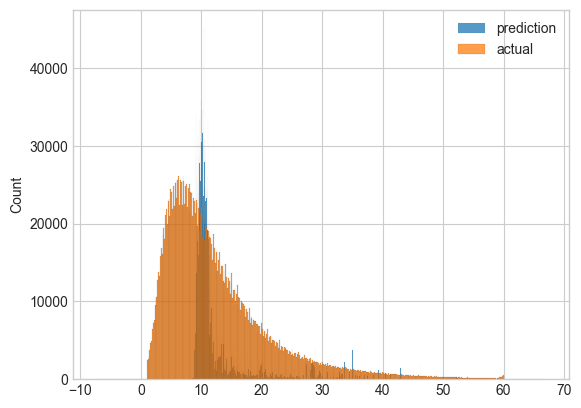

In [13]:
sns.histplot(y_pred, label='prediction')
sns.histplot(y_train, label='actual')

plt.legend();

## Q6. Evaluating the model

Now let's apply this model to the validation dataset (February 2022).

What's the RMSE on validation?
- 7.79 - _correct_
- 12.79
- 17.79
- 22.79

In [14]:
categorical = ['PULocationID', 'DOLocationID']

def read_data(filename):
    df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.dt.total_seconds() / 60

    df = df[(df.duration >= 1) & (df.duration <= 60)].copy()

    df[categorical] = df[categorical].astype('str')
    
    return df

In [15]:
df_val = read_data(feb_url)

val_dicts = df_val[categorical].to_dict(orient='records')

X_val = dv.transform(val_dicts) 
y_val = df_val.duration.values

y_pred = lr.predict(X_val)

val_rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f'Validation RMSE: {val_rmse:.2f}')

Validation RMSE: 7.79


## Submit the results

- Submit your results here: https://forms.gle/uYTnWrcsubi2gdGV7
- You can submit your solution multiple times. In this case, only the last submission will be used
- If your answer doesn't match options exactly, select the closest one

## Deadline

The deadline for submitting is 23 May 2023 (Tuesday), 23:00 CEST (Berlin time).

After that, the form will be closed.